### Set env variable value from Google Colab secret


In [2]:
import os
from google.colab import userdata
GCP_PROJECT_ID = userdata.get('GCP_PROJECT_ID')

os.environ["GCP_PROJECT_ID"] = GCP_PROJECT_ID

### Login to GCP project

In [ ]:
!gcloud auth login --no-launch-browser
!gcloud config set project $GCP_PROJECT_ID

### Download necessary input files from GCP bucket

In [5]:
%%capture
!pip install salesforce-lavis

In [6]:
%%capture

!gsutil cp gs://virtual-home-studio/vhome_medium_ds/v0_t1680_images.tar.gz .
!tar -xzvf v0_t1680_images.tar.gz
!nvidia-smi

Show size taken up by images

In [7]:
!du -sh images/


45M	images/


List number of images...

In [8]:
!ls images | wc -l

1680


Load BLIP caption base model, with finetuned checkpoints on MSCOCO captioning dataset. This also loads the associated image processors...

In [9]:
import torch
from PIL import Image
import requests
from lavis.models import load_model_and_preprocess

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 2.50G/2.50G [00:44<00:00, 60.8MB/s]


Verify caption generation using BLIP on few images and inspect outputs...

In [10]:
%%timeit
image_list = [
    "imageid_0032e85decdd414c8886643cd468d551.jpeg",
    "imageid_00345bb310cd45b9830c9020de22eb7e.jpeg",
    "imageid_003b0dd6d16d42db86bd9d93dcacd5a7.jpeg",
    "imageid_004200a650a0433b9af407979a40782c.jpeg",
    "imageid_00b62b8168914fc497b5da7e880e83cb.jpeg",
    "imageid_00cc4e6889dc4aecac6d700ccc126fc5.jpeg",
    "imageid_00e7511f64e44d47a701e4d78f434962.jpeg",
    "imageid_00e9a9b6c6074904a25874d8df4c3f8b.jpeg",
    "imageid_011c33019b0f471aa30191593617d745.jpeg",
    "imageid_012d090e5d924090aa49a1e6747234ac.jpeg",
]


img_captions = []
dir_prefix = "images/"
for img in image_list:
  # preprocess the image
  # vis_processors stores image transforms for "train" and "eval" (validation / testing / inference)
  raw_image = Image.open(dir_prefix + img).convert('RGB')
  image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
  # generate caption
  img_captions.append(model.generate({"image": image}))
print(img_captions)

[['a bathroom with a large white bathtub next to a sink'], ['a computer desk and chair in a room'], ['a woman standing in a room next to a man'], ['a bathroom with a white tiled wall and floor'], ['a computer desk with a monitor, keyboard and mouse'], ['a woman standing in a bathroom next to a washing machine'], ['a woman standing in a kitchen next to a table'], ['a bathroom with a red toilet and a white wall'], ['a computer desk with a laptop on top of it'], ['a living room with a white couch and a black coffee table']]
[['a bathroom with a large white bathtub next to a sink'], ['a computer desk and chair in a room'], ['a woman standing in a room next to a man'], ['a bathroom with a white tiled wall and floor'], ['a computer desk with a monitor, keyboard and mouse'], ['a woman standing in a bathroom next to a washing machine'], ['a woman standing in a kitchen next to a table'], ['a bathroom with a red toilet and a white wall'], ['a computer desk with a laptop on top of it'], ['a livin

Now that we've verified qualitatively on a few samples, generate captions for entire dataset...


In [ ]:
from pathlib import Path
from collections import OrderedDict

def create_captions():
  img_captions = {}
  dir_prefix = "images/"
  image_files = Path('images').glob('*.jpeg')

  for idx, img in enumerate(image_files):
    # preprocess the image
    # vis_processors stores image transforms for "train" and "eval" (validation / testing / inference)
    raw_image = Image.open(img).convert('RGB')
    image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
    # generate caption
    img_captions[str(img)]= model.generate({"image": image})
    print(f"Processed img {idx}")
  return img_captions

img_captions = create_captions()

Save to file for downstream use cases...

In [ ]:
import json
img_captions_json_data = json.dumps(img_captions)
with open("v0_t1680_image_2_captions.json", "w") as f:
    f.write(img_captions_json_data)

img_captions

Visually inspect a few samples...

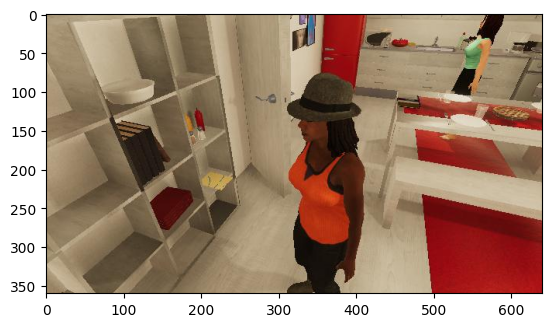

In [14]:
import matplotlib.pyplot as plt
image = plt.imread('images/imageid_55ca238de12d4b65a650207f050db124.jpeg')
plt.imshow(image)
plt.show()